# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 984us/sample - loss: 253.2249 - y1_output_loss: 117.5901 - y2_output_loss: 133.2326 - y1_output_root_mean_squared_error: 10.8961 - y2_output_root_mean_squared_error: 11.5974 - val_loss: 40.8694 - val_y1_output_loss: 17.2666 - val_y2_output_loss: 24.3872 - val_y1_output_root_mean_squared_error: 4.0676 - val_y2_output_root_mean_squared_error: 4.9319
Epoch 2/500
614/614 [==============================] - 0s 154us/sample - loss: 36.9013 - y1_output_loss: 13.1287 - y2_output_loss: 23.9770 - y1_output_root_mean_squared_error: 3.6190 - y2_output_root_mean_squared_error: 4.8790 - val_loss: 34.9933 - val_y1_output_loss: 14.2014 - val_y2_output_loss: 21.1523 - val_y1_output_root_mean_squared_error: 3.7054 - val_y2_output_root_mean_squared_error: 4.6112
Epoch 3/500
614/614 [==============================] - 0s 157us/sample - loss: 26.9188 - y1_output_loss: 9.8757 - y2_output_loss: 16.8295 - y1_

614/614 [==============================] - 0s 144us/sample - loss: 11.5006 - y1_output_loss: 4.5767 - y2_output_loss: 6.9459 - y1_output_root_mean_squared_error: 2.1377 - y2_output_root_mean_squared_error: 2.6327 - val_loss: 17.5201 - val_y1_output_loss: 7.0802 - val_y2_output_loss: 10.2697 - val_y1_output_root_mean_squared_error: 2.6415 - val_y2_output_root_mean_squared_error: 3.2469
Epoch 22/500
614/614 [==============================] - 0s 142us/sample - loss: 11.8347 - y1_output_loss: 4.5156 - y2_output_loss: 7.2806 - y1_output_root_mean_squared_error: 2.1304 - y2_output_root_mean_squared_error: 2.7011 - val_loss: 12.4850 - val_y1_output_loss: 5.1047 - val_y2_output_loss: 7.1025 - val_y1_output_root_mean_squared_error: 2.2892 - val_y2_output_root_mean_squared_error: 2.6915
Epoch 23/500
614/614 [==============================] - 0s 138us/sample - loss: 14.4055 - y1_output_loss: 4.5349 - y2_output_loss: 9.8161 - y1_output_root_mean_squared_error: 2.1385 - y2_output_root_mean_squared_

614/614 [==============================] - 0s 143us/sample - loss: 8.1891 - y1_output_loss: 2.5658 - y2_output_loss: 5.5982 - y1_output_root_mean_squared_error: 1.6072 - y2_output_root_mean_squared_error: 2.3677 - val_loss: 17.2063 - val_y1_output_loss: 3.7593 - val_y2_output_loss: 13.3139 - val_y1_output_root_mean_squared_error: 1.9665 - val_y2_output_root_mean_squared_error: 3.6523
Epoch 42/500
614/614 [==============================] - 0s 143us/sample - loss: 8.9404 - y1_output_loss: 2.7756 - y2_output_loss: 6.1765 - y1_output_root_mean_squared_error: 1.6653 - y2_output_root_mean_squared_error: 2.4834 - val_loss: 8.8918 - val_y1_output_loss: 3.7253 - val_y2_output_loss: 4.9641 - val_y1_output_root_mean_squared_error: 1.9476 - val_y2_output_root_mean_squared_error: 2.2580
Epoch 43/500
614/614 [==============================] - 0s 141us/sample - loss: 6.3324 - y1_output_loss: 1.9293 - y2_output_loss: 4.5029 - y1_output_root_mean_squared_error: 1.3896 - y2_output_root_mean_squared_erro

Epoch 62/500
614/614 [==============================] - 0s 137us/sample - loss: 4.3963 - y1_output_loss: 1.1781 - y2_output_loss: 3.2539 - y1_output_root_mean_squared_error: 1.0851 - y2_output_root_mean_squared_error: 1.7941 - val_loss: 4.2274 - val_y1_output_loss: 0.8843 - val_y2_output_loss: 3.2379 - val_y1_output_root_mean_squared_error: 0.9459 - val_y2_output_root_mean_squared_error: 1.8255
Epoch 63/500
614/614 [==============================] - 0s 140us/sample - loss: 4.0966 - y1_output_loss: 1.1631 - y2_output_loss: 2.9250 - y1_output_root_mean_squared_error: 1.0836 - y2_output_root_mean_squared_error: 1.7095 - val_loss: 4.7935 - val_y1_output_loss: 1.4135 - val_y2_output_loss: 3.3058 - val_y1_output_root_mean_squared_error: 1.1995 - val_y2_output_root_mean_squared_error: 1.8316
Epoch 64/500
614/614 [==============================] - 0s 148us/sample - loss: 5.3010 - y1_output_loss: 1.4646 - y2_output_loss: 3.8011 - y1_output_root_mean_squared_error: 1.2113 - y2_output_root_mean_s

Epoch 83/500
614/614 [==============================] - 0s 158us/sample - loss: 8.4205 - y1_output_loss: 2.3498 - y2_output_loss: 6.0024 - y1_output_root_mean_squared_error: 1.5380 - y2_output_root_mean_squared_error: 2.4607 - val_loss: 3.5771 - val_y1_output_loss: 0.8838 - val_y2_output_loss: 2.7005 - val_y1_output_root_mean_squared_error: 0.9502 - val_y2_output_root_mean_squared_error: 1.6353
Epoch 84/500
614/614 [==============================] - 0s 144us/sample - loss: 3.0893 - y1_output_loss: 0.7434 - y2_output_loss: 2.3396 - y1_output_root_mean_squared_error: 0.8551 - y2_output_root_mean_squared_error: 1.5356 - val_loss: 4.0122 - val_y1_output_loss: 1.3012 - val_y2_output_loss: 2.6888 - val_y1_output_root_mean_squared_error: 1.1576 - val_y2_output_root_mean_squared_error: 1.6347
Epoch 85/500
614/614 [==============================] - 0s 146us/sample - loss: 3.5424 - y1_output_loss: 0.9014 - y2_output_loss: 2.6699 - y1_output_root_mean_squared_error: 0.9524 - y2_output_root_mean_s

Epoch 104/500
614/614 [==============================] - 0s 146us/sample - loss: 2.2556 - y1_output_loss: 0.5884 - y2_output_loss: 1.6526 - y1_output_root_mean_squared_error: 0.7703 - y2_output_root_mean_squared_error: 1.2893 - val_loss: 2.0523 - val_y1_output_loss: 0.5185 - val_y2_output_loss: 1.5470 - val_y1_output_root_mean_squared_error: 0.7075 - val_y2_output_root_mean_squared_error: 1.2457
Epoch 105/500
614/614 [==============================] - 0s 142us/sample - loss: 2.2062 - y1_output_loss: 0.5705 - y2_output_loss: 1.6929 - y1_output_root_mean_squared_error: 0.7442 - y2_output_root_mean_squared_error: 1.2854 - val_loss: 8.1461 - val_y1_output_loss: 2.9236 - val_y2_output_loss: 5.1293 - val_y1_output_root_mean_squared_error: 1.7344 - val_y2_output_root_mean_squared_error: 2.2667
Epoch 106/500
614/614 [==============================] - 0s 137us/sample - loss: 3.4704 - y1_output_loss: 0.9378 - y2_output_loss: 2.5303 - y1_output_root_mean_squared_error: 0.9630 - y2_output_root_mea

614/614 [==============================] - 0s 136us/sample - loss: 1.7246 - y1_output_loss: 0.4098 - y2_output_loss: 1.3758 - y1_output_root_mean_squared_error: 0.6427 - y2_output_root_mean_squared_error: 1.1452 - val_loss: 37.2994 - val_y1_output_loss: 2.8462 - val_y2_output_loss: 34.1989 - val_y1_output_root_mean_squared_error: 1.7140 - val_y2_output_root_mean_squared_error: 5.8619
Epoch 125/500
614/614 [==============================] - 0s 141us/sample - loss: 2.4403 - y1_output_loss: 0.5634 - y2_output_loss: 1.8802 - y1_output_root_mean_squared_error: 0.7506 - y2_output_root_mean_squared_error: 1.3700 - val_loss: 4.5811 - val_y1_output_loss: 1.7019 - val_y2_output_loss: 2.7975 - val_y1_output_root_mean_squared_error: 1.3189 - val_y2_output_root_mean_squared_error: 1.6857
Epoch 126/500
614/614 [==============================] - 0s 144us/sample - loss: 4.6481 - y1_output_loss: 1.2980 - y2_output_loss: 3.3380 - y1_output_root_mean_squared_error: 1.1422 - y2_output_root_mean_squared_er

Epoch 145/500
614/614 [==============================] - 0s 144us/sample - loss: 2.2156 - y1_output_loss: 0.4988 - y2_output_loss: 1.7000 - y1_output_root_mean_squared_error: 0.7077 - y2_output_root_mean_squared_error: 1.3095 - val_loss: 1.3528 - val_y1_output_loss: 0.2619 - val_y2_output_loss: 1.0851 - val_y1_output_root_mean_squared_error: 0.5101 - val_y2_output_root_mean_squared_error: 1.0453
Epoch 146/500
614/614 [==============================] - 0s 141us/sample - loss: 1.6476 - y1_output_loss: 0.3948 - y2_output_loss: 1.2553 - y1_output_root_mean_squared_error: 0.6226 - y2_output_root_mean_squared_error: 1.1225 - val_loss: 2.0575 - val_y1_output_loss: 0.4398 - val_y2_output_loss: 1.6250 - val_y1_output_root_mean_squared_error: 0.6559 - val_y2_output_root_mean_squared_error: 1.2756
Epoch 147/500
614/614 [==============================] - 0s 140us/sample - loss: 1.8354 - y1_output_loss: 0.4107 - y2_output_loss: 1.4094 - y1_output_root_mean_squared_error: 0.6427 - y2_output_root_mea

614/614 [==============================] - 0s 143us/sample - loss: 1.5862 - y1_output_loss: 0.3094 - y2_output_loss: 1.2698 - y1_output_root_mean_squared_error: 0.5563 - y2_output_root_mean_squared_error: 1.1299 - val_loss: 1.1947 - val_y1_output_loss: 0.2294 - val_y2_output_loss: 0.9650 - val_y1_output_root_mean_squared_error: 0.4783 - val_y2_output_root_mean_squared_error: 0.9829
Epoch 166/500
614/614 [==============================] - 0s 135us/sample - loss: 1.6563 - y1_output_loss: 0.4588 - y2_output_loss: 1.1975 - y1_output_root_mean_squared_error: 0.6790 - y2_output_root_mean_squared_error: 1.0932 - val_loss: 1.9021 - val_y1_output_loss: 0.2003 - val_y2_output_loss: 1.6545 - val_y1_output_root_mean_squared_error: 0.4437 - val_y2_output_root_mean_squared_error: 1.3058
Epoch 167/500
614/614 [==============================] - 0s 162us/sample - loss: 1.3035 - y1_output_loss: 0.3105 - y2_output_loss: 0.9915 - y1_output_root_mean_squared_error: 0.5572 - y2_output_root_mean_squared_erro

Epoch 186/500
614/614 [==============================] - 0s 146us/sample - loss: 1.3083 - y1_output_loss: 0.2845 - y2_output_loss: 1.0127 - y1_output_root_mean_squared_error: 0.5354 - y2_output_root_mean_squared_error: 1.0108 - val_loss: 1.2264 - val_y1_output_loss: 0.1987 - val_y2_output_loss: 1.0389 - val_y1_output_root_mean_squared_error: 0.4467 - val_y2_output_root_mean_squared_error: 1.0133
Epoch 187/500
614/614 [==============================] - 0s 134us/sample - loss: 1.3415 - y1_output_loss: 0.3238 - y2_output_loss: 1.0092 - y1_output_root_mean_squared_error: 0.5704 - y2_output_root_mean_squared_error: 1.0080 - val_loss: 1.0091 - val_y1_output_loss: 0.1729 - val_y2_output_loss: 0.8381 - val_y1_output_root_mean_squared_error: 0.4165 - val_y2_output_root_mean_squared_error: 0.9141
Epoch 188/500
614/614 [==============================] - 0s 144us/sample - loss: 1.0798 - y1_output_loss: 0.2431 - y2_output_loss: 0.8294 - y1_output_root_mean_squared_error: 0.4941 - y2_output_root_mea

614/614 [==============================] - 0s 138us/sample - loss: 1.8060 - y1_output_loss: 0.3951 - y2_output_loss: 1.4069 - y1_output_root_mean_squared_error: 0.6312 - y2_output_root_mean_squared_error: 1.1864 - val_loss: 1.7632 - val_y1_output_loss: 0.2829 - val_y2_output_loss: 1.4775 - val_y1_output_root_mean_squared_error: 0.5384 - val_y2_output_root_mean_squared_error: 1.2138
Epoch 207/500
614/614 [==============================] - 0s 145us/sample - loss: 1.1198 - y1_output_loss: 0.2355 - y2_output_loss: 0.8915 - y1_output_root_mean_squared_error: 0.4866 - y2_output_root_mean_squared_error: 0.9397 - val_loss: 1.7107 - val_y1_output_loss: 0.1747 - val_y2_output_loss: 1.5018 - val_y1_output_root_mean_squared_error: 0.4178 - val_y2_output_root_mean_squared_error: 1.2394
Epoch 208/500
614/614 [==============================] - 0s 140us/sample - loss: 1.2252 - y1_output_loss: 0.2636 - y2_output_loss: 0.9541 - y1_output_root_mean_squared_error: 0.5144 - y2_output_root_mean_squared_erro

Epoch 227/500
614/614 [==============================] - 0s 143us/sample - loss: 1.2430 - y1_output_loss: 0.2987 - y2_output_loss: 0.9335 - y1_output_root_mean_squared_error: 0.5482 - y2_output_root_mean_squared_error: 0.9708 - val_loss: 1.1713 - val_y1_output_loss: 0.2363 - val_y2_output_loss: 0.9769 - val_y1_output_root_mean_squared_error: 0.4936 - val_y2_output_root_mean_squared_error: 0.9631
Epoch 228/500
614/614 [==============================] - 0s 142us/sample - loss: 0.8090 - y1_output_loss: 0.2207 - y2_output_loss: 0.5902 - y1_output_root_mean_squared_error: 0.4688 - y2_output_root_mean_squared_error: 0.7676 - val_loss: 1.1914 - val_y1_output_loss: 0.3011 - val_y2_output_loss: 0.9089 - val_y1_output_root_mean_squared_error: 0.5496 - val_y2_output_root_mean_squared_error: 0.9431
Epoch 229/500
614/614 [==============================] - 0s 145us/sample - loss: 0.9096 - y1_output_loss: 0.2410 - y2_output_loss: 0.6693 - y1_output_root_mean_squared_error: 0.4917 - y2_output_root_mea

614/614 [==============================] - 0s 144us/sample - loss: 0.7708 - y1_output_loss: 0.1934 - y2_output_loss: 0.5731 - y1_output_root_mean_squared_error: 0.4413 - y2_output_root_mean_squared_error: 0.7590 - val_loss: 0.9962 - val_y1_output_loss: 0.1698 - val_y2_output_loss: 0.8206 - val_y1_output_root_mean_squared_error: 0.4145 - val_y2_output_root_mean_squared_error: 0.9080
Epoch 248/500
614/614 [==============================] - 0s 168us/sample - loss: 0.9582 - y1_output_loss: 0.2114 - y2_output_loss: 0.7384 - y1_output_root_mean_squared_error: 0.4615 - y2_output_root_mean_squared_error: 0.8633 - val_loss: 1.2252 - val_y1_output_loss: 0.2313 - val_y2_output_loss: 0.9981 - val_y1_output_root_mean_squared_error: 0.4853 - val_y2_output_root_mean_squared_error: 0.9948
Epoch 249/500
614/614 [==============================] - 0s 152us/sample - loss: 0.8243 - y1_output_loss: 0.1736 - y2_output_loss: 0.6653 - y1_output_root_mean_squared_error: 0.4147 - y2_output_root_mean_squared_erro

Epoch 268/500
614/614 [==============================] - 0s 142us/sample - loss: 0.6794 - y1_output_loss: 0.1854 - y2_output_loss: 0.4941 - y1_output_root_mean_squared_error: 0.4309 - y2_output_root_mean_squared_error: 0.7027 - val_loss: 1.3403 - val_y1_output_loss: 0.3079 - val_y2_output_loss: 1.0468 - val_y1_output_root_mean_squared_error: 0.5614 - val_y2_output_root_mean_squared_error: 1.0125
Epoch 269/500
614/614 [==============================] - 0s 142us/sample - loss: 0.5235 - y1_output_loss: 0.1385 - y2_output_loss: 0.3868 - y1_output_root_mean_squared_error: 0.3736 - y2_output_root_mean_squared_error: 0.6196 - val_loss: 1.5992 - val_y1_output_loss: 0.2304 - val_y2_output_loss: 1.3282 - val_y1_output_root_mean_squared_error: 0.4788 - val_y2_output_root_mean_squared_error: 1.1705
Epoch 270/500
614/614 [==============================] - 0s 140us/sample - loss: 0.6114 - y1_output_loss: 0.1507 - y2_output_loss: 0.4568 - y1_output_root_mean_squared_error: 0.3891 - y2_output_root_mea

614/614 [==============================] - 0s 135us/sample - loss: 1.0520 - y1_output_loss: 0.2600 - y2_output_loss: 0.7882 - y1_output_root_mean_squared_error: 0.5123 - y2_output_root_mean_squared_error: 0.8885 - val_loss: 1.0745 - val_y1_output_loss: 0.2563 - val_y2_output_loss: 0.8024 - val_y1_output_root_mean_squared_error: 0.5079 - val_y2_output_root_mean_squared_error: 0.9036
Epoch 289/500
614/614 [==============================] - 0s 159us/sample - loss: 0.7811 - y1_output_loss: 0.1927 - y2_output_loss: 0.5875 - y1_output_root_mean_squared_error: 0.4385 - y2_output_root_mean_squared_error: 0.7674 - val_loss: 1.2424 - val_y1_output_loss: 0.3163 - val_y2_output_loss: 0.8960 - val_y1_output_root_mean_squared_error: 0.5616 - val_y2_output_root_mean_squared_error: 0.9628
Epoch 290/500
614/614 [==============================] - 0s 143us/sample - loss: 0.6638 - y1_output_loss: 0.1596 - y2_output_loss: 0.5202 - y1_output_root_mean_squared_error: 0.4000 - y2_output_root_mean_squared_erro

Epoch 309/500
614/614 [==============================] - 0s 146us/sample - loss: 0.6847 - y1_output_loss: 0.1515 - y2_output_loss: 0.5278 - y1_output_root_mean_squared_error: 0.3902 - y2_output_root_mean_squared_error: 0.7297 - val_loss: 0.9410 - val_y1_output_loss: 0.2127 - val_y2_output_loss: 0.7540 - val_y1_output_root_mean_squared_error: 0.4501 - val_y2_output_root_mean_squared_error: 0.8593
Epoch 310/500
614/614 [==============================] - 0s 141us/sample - loss: 0.5306 - y1_output_loss: 0.1528 - y2_output_loss: 0.3771 - y1_output_root_mean_squared_error: 0.3911 - y2_output_root_mean_squared_error: 0.6145 - val_loss: 0.8075 - val_y1_output_loss: 0.2169 - val_y2_output_loss: 0.5894 - val_y1_output_root_mean_squared_error: 0.4616 - val_y2_output_root_mean_squared_error: 0.7710
Epoch 311/500
614/614 [==============================] - 0s 150us/sample - loss: 0.5184 - y1_output_loss: 0.1480 - y2_output_loss: 0.3688 - y1_output_root_mean_squared_error: 0.3858 - y2_output_root_mea

614/614 [==============================] - 0s 141us/sample - loss: 0.4598 - y1_output_loss: 0.1432 - y2_output_loss: 0.3147 - y1_output_root_mean_squared_error: 0.3794 - y2_output_root_mean_squared_error: 0.5620 - val_loss: 0.8652 - val_y1_output_loss: 0.1931 - val_y2_output_loss: 0.6559 - val_y1_output_root_mean_squared_error: 0.4413 - val_y2_output_root_mean_squared_error: 0.8188
Epoch 330/500
614/614 [==============================] - 0s 142us/sample - loss: 0.6346 - y1_output_loss: 0.1669 - y2_output_loss: 0.4773 - y1_output_root_mean_squared_error: 0.4091 - y2_output_root_mean_squared_error: 0.6835 - val_loss: 6.1658 - val_y1_output_loss: 0.6217 - val_y2_output_loss: 5.5537 - val_y1_output_root_mean_squared_error: 0.7980 - val_y2_output_root_mean_squared_error: 2.3514
Epoch 331/500
614/614 [==============================] - 0s 155us/sample - loss: 0.6427 - y1_output_loss: 0.1819 - y2_output_loss: 0.4586 - y1_output_root_mean_squared_error: 0.4279 - y2_output_root_mean_squared_erro

Epoch 350/500
614/614 [==============================] - 0s 138us/sample - loss: 0.5276 - y1_output_loss: 0.1615 - y2_output_loss: 0.3623 - y1_output_root_mean_squared_error: 0.4027 - y2_output_root_mean_squared_error: 0.6046 - val_loss: 0.7847 - val_y1_output_loss: 0.2055 - val_y2_output_loss: 0.5758 - val_y1_output_root_mean_squared_error: 0.4490 - val_y2_output_root_mean_squared_error: 0.7636
Epoch 351/500
614/614 [==============================] - 0s 143us/sample - loss: 0.4354 - y1_output_loss: 0.1184 - y2_output_loss: 0.3224 - y1_output_root_mean_squared_error: 0.3432 - y2_output_root_mean_squared_error: 0.5635 - val_loss: 1.1007 - val_y1_output_loss: 0.3120 - val_y2_output_loss: 0.7645 - val_y1_output_root_mean_squared_error: 0.5598 - val_y2_output_root_mean_squared_error: 0.8873
Epoch 352/500
614/614 [==============================] - 0s 142us/sample - loss: 0.6424 - y1_output_loss: 0.1722 - y2_output_loss: 0.4696 - y1_output_root_mean_squared_error: 0.4129 - y2_output_root_mea

614/614 [==============================] - 0s 140us/sample - loss: 0.6379 - y1_output_loss: 0.1567 - y2_output_loss: 0.4816 - y1_output_root_mean_squared_error: 0.3971 - y2_output_root_mean_squared_error: 0.6930 - val_loss: 1.2700 - val_y1_output_loss: 0.1620 - val_y2_output_loss: 1.1170 - val_y1_output_root_mean_squared_error: 0.3994 - val_y2_output_root_mean_squared_error: 1.0538
Epoch 371/500
614/614 [==============================] - 0s 141us/sample - loss: 0.4831 - y1_output_loss: 0.1237 - y2_output_loss: 0.3576 - y1_output_root_mean_squared_error: 0.3519 - y2_output_root_mean_squared_error: 0.5993 - val_loss: 1.2914 - val_y1_output_loss: 0.2525 - val_y2_output_loss: 1.0546 - val_y1_output_root_mean_squared_error: 0.5028 - val_y2_output_root_mean_squared_error: 1.0191
Epoch 372/500
614/614 [==============================] - 0s 141us/sample - loss: 0.3597 - y1_output_loss: 0.1047 - y2_output_loss: 0.2530 - y1_output_root_mean_squared_error: 0.3235 - y2_output_root_mean_squared_erro

Epoch 391/500
614/614 [==============================] - 0s 144us/sample - loss: 0.4562 - y1_output_loss: 0.1254 - y2_output_loss: 0.3369 - y1_output_root_mean_squared_error: 0.3504 - y2_output_root_mean_squared_error: 0.5774 - val_loss: 4.3128 - val_y1_output_loss: 1.3939 - val_y2_output_loss: 2.8180 - val_y1_output_root_mean_squared_error: 1.1897 - val_y2_output_root_mean_squared_error: 1.7021
Epoch 392/500
614/614 [==============================] - 0s 145us/sample - loss: 0.6953 - y1_output_loss: 0.2022 - y2_output_loss: 0.5153 - y1_output_root_mean_squared_error: 0.4447 - y2_output_root_mean_squared_error: 0.7054 - val_loss: 1.5839 - val_y1_output_loss: 0.2148 - val_y2_output_loss: 1.3336 - val_y1_output_root_mean_squared_error: 0.4642 - val_y2_output_root_mean_squared_error: 1.1698
Epoch 393/500
614/614 [==============================] - 0s 143us/sample - loss: 0.5186 - y1_output_loss: 0.1569 - y2_output_loss: 0.3591 - y1_output_root_mean_squared_error: 0.3955 - y2_output_root_mea

614/614 [==============================] - 0s 142us/sample - loss: 0.4475 - y1_output_loss: 0.1448 - y2_output_loss: 0.3050 - y1_output_root_mean_squared_error: 0.3796 - y2_output_root_mean_squared_error: 0.5509 - val_loss: 1.1140 - val_y1_output_loss: 0.2385 - val_y2_output_loss: 0.8536 - val_y1_output_root_mean_squared_error: 0.4820 - val_y2_output_root_mean_squared_error: 0.9390
Epoch 412/500
614/614 [==============================] - 0s 136us/sample - loss: 0.3337 - y1_output_loss: 0.1192 - y2_output_loss: 0.2257 - y1_output_root_mean_squared_error: 0.3400 - y2_output_root_mean_squared_error: 0.4670 - val_loss: 1.9384 - val_y1_output_loss: 0.4600 - val_y2_output_loss: 1.4249 - val_y1_output_root_mean_squared_error: 0.6813 - val_y2_output_root_mean_squared_error: 1.2142
Epoch 413/500
614/614 [==============================] - 0s 166us/sample - loss: 0.4931 - y1_output_loss: 0.1555 - y2_output_loss: 0.3472 - y1_output_root_mean_squared_error: 0.3958 - y2_output_root_mean_squared_erro

Epoch 432/500
614/614 [==============================] - 0s 136us/sample - loss: 0.3395 - y1_output_loss: 0.1108 - y2_output_loss: 0.2290 - y1_output_root_mean_squared_error: 0.3336 - y2_output_root_mean_squared_error: 0.4777 - val_loss: 0.8410 - val_y1_output_loss: 0.1806 - val_y2_output_loss: 0.6471 - val_y1_output_root_mean_squared_error: 0.4171 - val_y2_output_root_mean_squared_error: 0.8167
Epoch 433/500
614/614 [==============================] - 0s 141us/sample - loss: 0.3511 - y1_output_loss: 0.1112 - y2_output_loss: 0.2402 - y1_output_root_mean_squared_error: 0.3341 - y2_output_root_mean_squared_error: 0.4894 - val_loss: 0.8985 - val_y1_output_loss: 0.1927 - val_y2_output_loss: 0.6998 - val_y1_output_root_mean_squared_error: 0.4426 - val_y2_output_root_mean_squared_error: 0.8382
Epoch 434/500
614/614 [==============================] - 0s 141us/sample - loss: 0.4006 - y1_output_loss: 0.1256 - y2_output_loss: 0.2716 - y1_output_root_mean_squared_error: 0.3559 - y2_output_root_mea

614/614 [==============================] - 0s 140us/sample - loss: 0.3546 - y1_output_loss: 0.1121 - y2_output_loss: 0.2421 - y1_output_root_mean_squared_error: 0.3360 - y2_output_root_mean_squared_error: 0.4916 - val_loss: 0.8129 - val_y1_output_loss: 0.2043 - val_y2_output_loss: 0.5946 - val_y1_output_root_mean_squared_error: 0.4489 - val_y2_output_root_mean_squared_error: 0.7819
Epoch 453/500
614/614 [==============================] - 0s 145us/sample - loss: 0.8151 - y1_output_loss: 0.2679 - y2_output_loss: 0.5419 - y1_output_root_mean_squared_error: 0.5191 - y2_output_root_mean_squared_error: 0.7387 - val_loss: 0.6715 - val_y1_output_loss: 0.1462 - val_y2_output_loss: 0.5581 - val_y1_output_root_mean_squared_error: 0.3821 - val_y2_output_root_mean_squared_error: 0.7249
Epoch 454/500
614/614 [==============================] - 0s 149us/sample - loss: 0.3456 - y1_output_loss: 0.1197 - y2_output_loss: 0.2260 - y1_output_root_mean_squared_error: 0.3470 - y2_output_root_mean_squared_erro

Epoch 473/500
614/614 [==============================] - 0s 148us/sample - loss: 0.3060 - y1_output_loss: 0.1095 - y2_output_loss: 0.1945 - y1_output_root_mean_squared_error: 0.3316 - y2_output_root_mean_squared_error: 0.4428 - val_loss: 0.6339 - val_y1_output_loss: 0.1754 - val_y2_output_loss: 0.4631 - val_y1_output_root_mean_squared_error: 0.4182 - val_y2_output_root_mean_squared_error: 0.6775
Epoch 474/500
614/614 [==============================] - 0s 134us/sample - loss: 0.3370 - y1_output_loss: 0.1203 - y2_output_loss: 0.2179 - y1_output_root_mean_squared_error: 0.3464 - y2_output_root_mean_squared_error: 0.4659 - val_loss: 0.7776 - val_y1_output_loss: 0.1778 - val_y2_output_loss: 0.6063 - val_y1_output_root_mean_squared_error: 0.4226 - val_y2_output_root_mean_squared_error: 0.7740
Epoch 475/500
614/614 [==============================] - 0s 140us/sample - loss: 0.3733 - y1_output_loss: 0.1142 - y2_output_loss: 0.2581 - y1_output_root_mean_squared_error: 0.3384 - y2_output_root_mea

614/614 [==============================] - 0s 151us/sample - loss: 0.3282 - y1_output_loss: 0.1162 - y2_output_loss: 0.2097 - y1_output_root_mean_squared_error: 0.3419 - y2_output_root_mean_squared_error: 0.4597 - val_loss: 0.6073 - val_y1_output_loss: 0.1755 - val_y2_output_loss: 0.4345 - val_y1_output_root_mean_squared_error: 0.4149 - val_y2_output_root_mean_squared_error: 0.6597
Epoch 494/500
614/614 [==============================] - 0s 140us/sample - loss: 0.3262 - y1_output_loss: 0.1181 - y2_output_loss: 0.2082 - y1_output_root_mean_squared_error: 0.3432 - y2_output_root_mean_squared_error: 0.4565 - val_loss: 0.8498 - val_y1_output_loss: 0.2530 - val_y2_output_loss: 0.6010 - val_y1_output_root_mean_squared_error: 0.5075 - val_y2_output_root_mean_squared_error: 0.7696
Epoch 495/500
614/614 [==============================] - 0s 140us/sample - loss: 0.7033 - y1_output_loss: 0.2135 - y2_output_loss: 0.4870 - y1_output_root_mean_squared_error: 0.4613 - y2_output_root_mean_squared_erro

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 39us/sample - loss: 0.7467 - y1_output_loss: 0.1971 - y2_output_loss: 0.5432 - y1_output_root_mean_squared_error: 0.4441 - y2_output_root_mean_squared_error: 0.7412
Loss = 0.7466870917902364, Y1_loss = 0.19708481431007385, Y1_mse = 0.44414809346199036, Y2_loss = 0.5431649088859558, Y2_mse = 0.7412284016609192


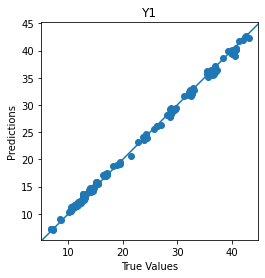

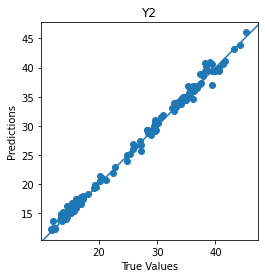

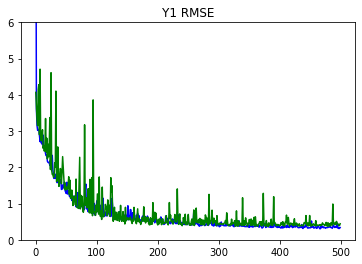

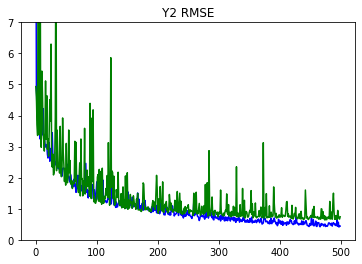

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)